In [ ]:
%%bash

gdown 'https://drive.google.com/uc?id=13maFB1wPrej6kn9n5jUp3hm9xL-AhJsN'
rm -rf sample_data
unzip lfwa.zip
rm -rf lfwa.zip
# gdown 'https://drive.google.com/uc?id=1gajejNguoHcussvG-xx9-eep5XT8ir_G'
# tar -xvf vgg_face_dataset.tar.gz
# mkdir vgg_face_dataset_images
# rm -rf vgg_face_dataset.tar.gz

In [2]:
import os
import shutil
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [3]:
ROOT_DIR = os.path.abspath('lfw2/lfw2')
TRAIN_DIR = os.path.abspath('lfw2/train')
TEST_DIR = os.path.abspath('lfw2/test')

os.makedirs(TEST_DIR, exist_ok=True)
os.makedirs(TRAIN_DIR, exist_ok=True)

In [4]:
dataset = [
           person for person in os.listdir(ROOT_DIR) 
           if len(os.listdir(os.path.join(ROOT_DIR, person))) >= 8
]

In [5]:
for person in tqdm(dataset, total=len(dataset)):
    shutil.copytree(
        os.path.join(ROOT_DIR, person), 
        os.path.join(TRAIN_DIR, person))

100%|██████████| 217/217 [00:00<00:00, 284.80it/s]


In [6]:
for person in tqdm(dataset, total=len(dataset)):
    for img in np.random.choice(os.listdir(os.path.join(ROOT_DIR, person)), 3):
        os.makedirs(os.path.join(TEST_DIR, person), exist_ok=True)
        shutil.copy(os.path.join(ROOT_DIR, person, img), os.path.join(TEST_DIR, person))

100%|██████████| 217/217 [00:00<00:00, 1330.04it/s]


In [ ]:
class FaceDataset(Dataset):
    def __init__(self, folder_dataset, transform = None):
        self.folder_dataset = folder_dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.folder_dataset)
    
    def __getitem__(self, idx):
        anchor_img_path = self.folder_dataset.imgs[np.random.randint(0, len(self.folder_dataset))][0]
        img_dir, img_name = anchor_img_path.split('/')[:-1], anchor_img_path.split('/')[-1]

        while True:
            positive_img_path = os.path.join("/".join(img_dir), np.random.choice(os.listdir("/".join(img_dir))))
            if positive_img_path != anchor_img_path: break

        while True:
            negative_img_path = self.folder_dataset.imgs[np.random.randint(0, len(self.folder_dataset))][0]
            if negative_img_path not in [anchor_img_path, positive_img_path]: break
        
        anchor_img = Image.open(anchor_img_path)
        positive_img = Image.open(positive_img_path)
        negative_img = Image.open(negative_img_path)

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
        
        return anchor_img, positive_img, negative_img

Text(0.5, 1.0, 'Negative')

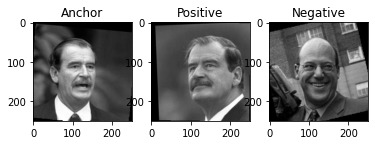

In [ ]:
dataset = FaceDataset(datasets.ImageFolder(TRAIN_DIR))
anchor, positive, negative = dataset[0]

plt.subplot(1,3,1)
plt.imshow(anchor, cmap='gray')
plt.title('Anchor')

plt.subplot(1,3,2)
plt.imshow(positive, cmap='gray')
plt.title('Positive')

plt.subplot(1,3,3)
plt.imshow(negative, cmap='gray')
plt.title('Negative')

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential( 
        nn.Conv2d(1, 96, kernel_size=11,stride=1),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
        nn.MaxPool2d(3, stride=2),

        nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout2d(p=0.3),

        nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout2d(p=0.3),
        )

        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
        # First Dense Layer
        nn.Linear(30976, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.5),
        # Second Dense Layer
        nn.Linear(1024, 128),
        nn.ReLU(inplace=True),
        # Final Dense Layer
        nn.Linear(128,2))

    def forward(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward_triple(self, anchor, positive, negative): #Use for computing triplet loss
        anchor_output = self.forward(anchor)
        positive_output = self.forward(positive)
        negative_output = self.forward(negative)
        
        return anchor_output, positive_output, negative_output

In [ ]:
class Maxout(nn.Module):

    def __init__(self, in_size, out_size, pool_size):
        super().__init__()
        self.in_size, self.out_size, self.pool_size = in_size, out_size, pool_size
        self.lin = nn.Linear(in_size, out_size * pool_size)


    def forward(self, inputs):
        shape = list(inputs.size())
        shape[-1] = self.out_size
        shape.append(self.pool_size)
        max_dim = len(shape) - 1
        out = self.lin(inputs)
        m, i = out.view(*shape).max(max_dim)
        return m

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        #Explanation of Conv2d(x,y,z):
        #      Build a convolutional layer with
        #            x input channels
        #            y output channels
        #            z*z filter
        self.model1 = nn.Sequential(
        nn.Conv2d(3,64,7,stride=2,padding=3),
        nn.MaxPool2d(3,stride=2,padding=1)
        )

        self.model2 = nn.Sequential(
        nn.Conv2d(64,64,1,stride=1),
        nn.Conv2d(64,192,3,stride=1,padding=1)
        )

        self.model3 = nn.Sequential(
        nn.MaxPool2d(3,stride=2,padding=1),
        nn.Conv2d(192,192,1,stride=1),
        nn.Conv2d(192,384,3,stride=1,padding=1),
        nn.MaxPool2d(3,stride=2,padding=1),
        nn.Conv2d(384,384,1,stride=1),
        nn.Conv2d(384,256,3,stride=1,padding=1),
        nn.Conv2d(256,256,1,stride=1),
        nn.Conv2d(256,256,3,stride=1,padding=1),
        nn.Conv2d(256,256,1,stride=1),
        nn.Conv2d(256,256,3,stride=1,padding=1),
        nn.MaxPool2d(3,stride=2,padding=1)
        )

        self.model4 = nn.Sequential(
        Maxout(7*7*256, 1*32*128, 2),
        Maxout(1*32*128, 1*32*128, 2),
        nn.Linear(1*32*128, 1*1*128),
        nn.Linear(128,128)
        )


    #Fucntion to feed forward

    def forward(self, x): #Go through network once
        # Max pooling over a (2, 2) window
        #x = x.type('torch.cuda.FloatTensor')
        x = F.normalize(x)
        x = self.model1(x)
        x = F.normalize(x)
        x = self.model2(x)
        x = F.normalize(x)
        x = self.model3(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.model4(x)

        return x

    def forward_triple(self, anchor, positive, negative): #Use for computing triplet loss
        anchor_output = self.forward(anchor)
        positive_output = self.forward(positive)
        negative_output = self.forward(negative)
        return anchor_output, positive_output, negative_output

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
model = SiameseNetwork()
anchor_output, positive_output, negative_output = model.forward_triple(torch.tensor(np.random.randn(1, 1, 224, 224)).float(),
                     torch.tensor(np.random.randn(1, 1, 224, 224)).float(),
                     torch.tensor(np.random.randn(1, 1, 224, 224)).float())

In [ ]:
anchor_output.shape, positive_output.shape, negative_output.shape

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin = 0.2):
        super(TripletLoss,self).__init__()
        self.margin= margin

    def forward(self, anchor, positive, negative):
        APDistance = (anchor - positive).pow(2).sum(1)
        ANDistance = (anchor - negative).pow(2).sum(1)
        loss = F.relu(APDistance - ANDistance + self.margin)
        return loss.sum()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
composed = transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.ToTensor()
])
trainDataset = FaceDataset(datasets.ImageFolder(TRAIN_DIR), composed)
trainDataloader = DataLoader(trainDataset, batch_size=64, shuffle=True, num_workers=2)
net = SiameseNetwork().to(device)
criterion = TripletLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05)
for epoch in range(24):
    for i, data in enumerate(trainDataloader,0):
        anchor, positive, negative = data
        anchor.to(device)
        positive.to(device)
        negative.to(device)
        anchor_out, positive_out, negative_out = net.forward_triple(anchor, positive, negative)
        optimizer.zero_grad()
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print('Current loss: %.3f' %(float(loss.data.cpu().numpy())))